In [1]:
%reload_ext autoreload
%autoreload 2

import os
os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

from watttime import WattTimeHistorical

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
chi = pd.read_csv(f"/home/{os.getlogin()}/watttime_historical_csvs/PJM_CHICAGO_co2_moer_2023-01-01_2024-08-01.csv")
chi["region"] = "PJM_CHICAGO"
nj = pd.read_csv(f"/home/{os.getlogin()}/watttime_historical_csvs/PJM_NJ_co2_moer_2023-01-01_2024-08-01.csv")
nj["region"] = "PJM_NJ"

In [3]:
df = pd.concat([chi,nj])

In [4]:
del nj
del chi

In [5]:
df.reset_index(inplace=True, drop=True)

## TZ Conversion

In [6]:
df["time_est"] = pd.to_datetime(df["point_time"], utc=True).map(lambda x: x.tz_convert('America/New_York'))
df["date_est"]  = df.time_est.dt.date
df["hour_est"]  = df.time_est.dt.hour
df["month_est"] = df.time_est.dt.month
df["weekday"] = df.time_est.dt.weekday
df["year"] = df.time_est.dt.year
df["year-month"] = df["year"].astype(str) + '-' + df["time_est"].astype(str)

In [7]:
df = df.query('year > 2022')

## Load Shifting Potential

In [8]:
# CO2 per 1 kWh of energy = 1.15
df.groupby(["year","region"]).value.mean() / 1000

year  region     
2023  PJM_CHICAGO    1.160705
      PJM_NJ         1.176113
2024  PJM_CHICAGO    1.139406
      PJM_NJ         1.207825
Name: value, dtype: float64

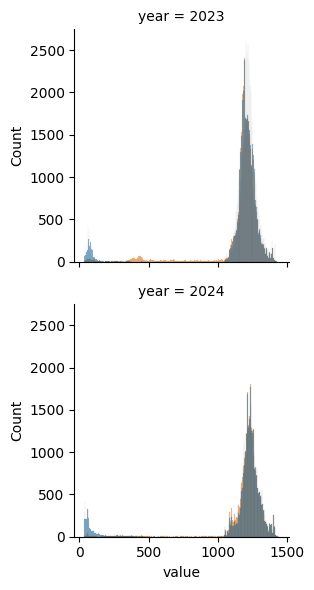

In [16]:
g = sns.FacetGrid(df, row="year",sharex=True)
g.map_dataframe(sns.histplot, x = "value", hue = "region")
g.add_legend()

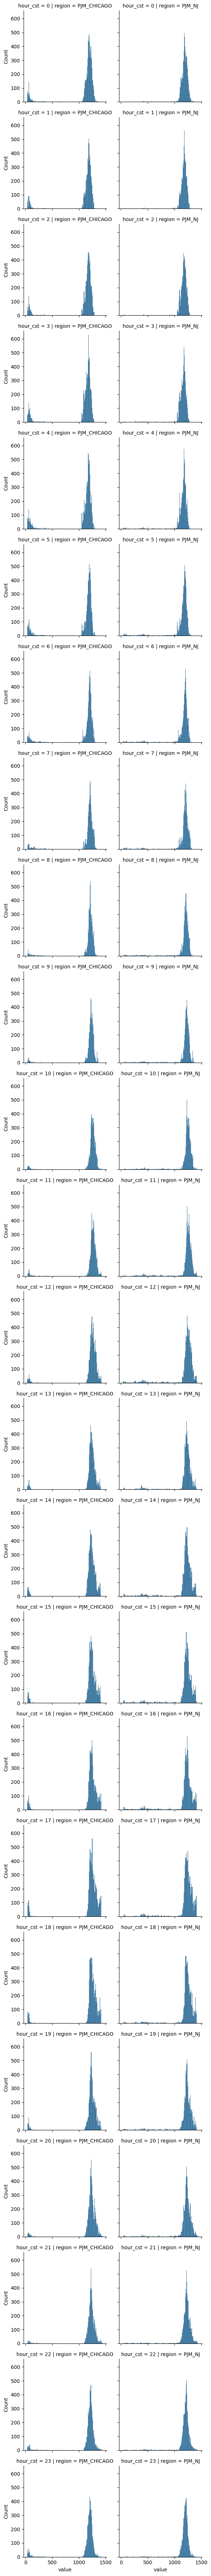

In [17]:
g = sns.FacetGrid(df, col="region",row="hour_est", sharex=True)
g.map(sns.histplot,"value")

<Figure size 2500x800 with 0 Axes>

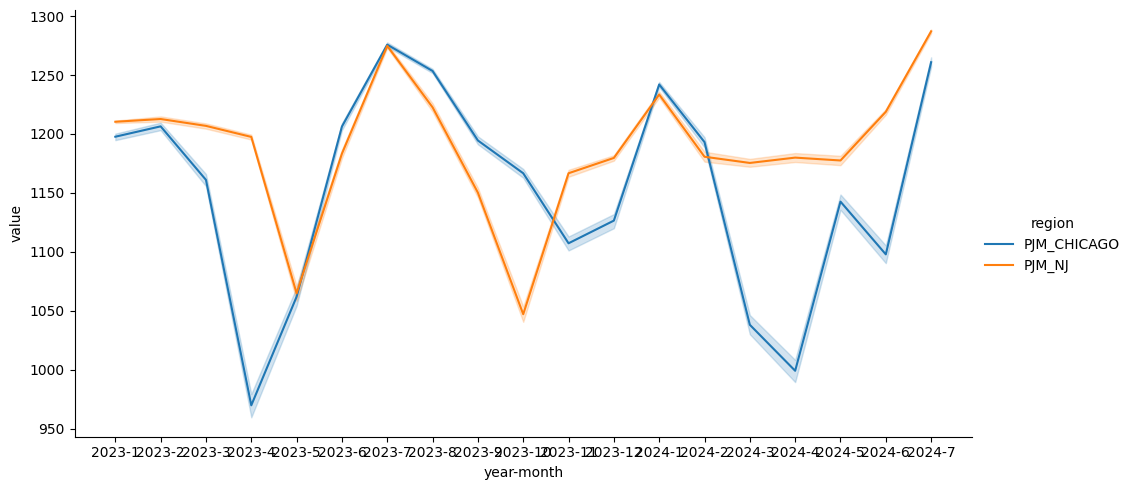

In [23]:
f = plt.figure(figsize=(25,8))
sns.relplot(
    data=df,
    kind="line",
    x="year-month", 
    y="value",
    hue="region",
    aspect = 2,
    legend='full'
)

<Figure size 2000x800 with 0 Axes>

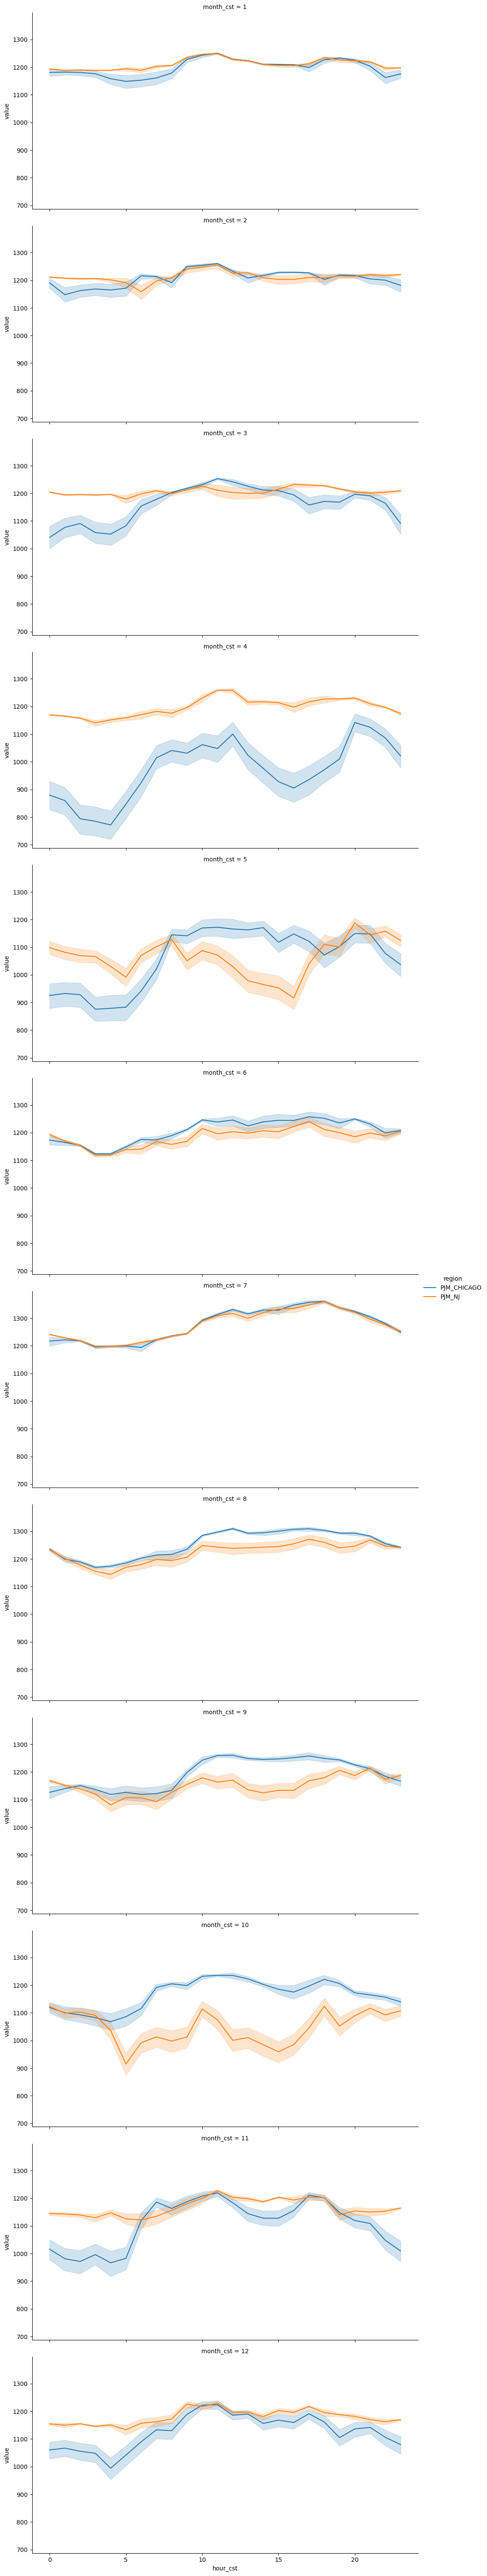

In [10]:
f = plt.figure(figsize=(20,8))
sns.relplot(
    data=df.query('date_cst < datetime.date(2024, 1, 1)'),
    kind="line",
    x="hour_cst", 
    y="value",
    hue="region",
    row="month_cst",
    aspect = 2,
    legend='full'
)

f.show()

In [24]:
df.pivot(index='point_time',columns='region',values='value').corr(method="spearman")

region,PJM_CHICAGO,PJM_NJ
region,,
PJM_CHICAGO,1.000000,0.831769
PJM_NJ,0.831769,1.000000


In [ ]:
f = plt.figure(figsize=(20,8))
sns.relplot(
    data=df.query('year < 2024'),
    kind="line",
    x="hour_cst", 
    y="value",
    hue="month_cst",
    row="region",
    aspect = 2,
    palette = plt.get_cmap('coolwarm',12),
    legend='full'
)

f.show()

<Figure size 2000x800 with 0 Axes>

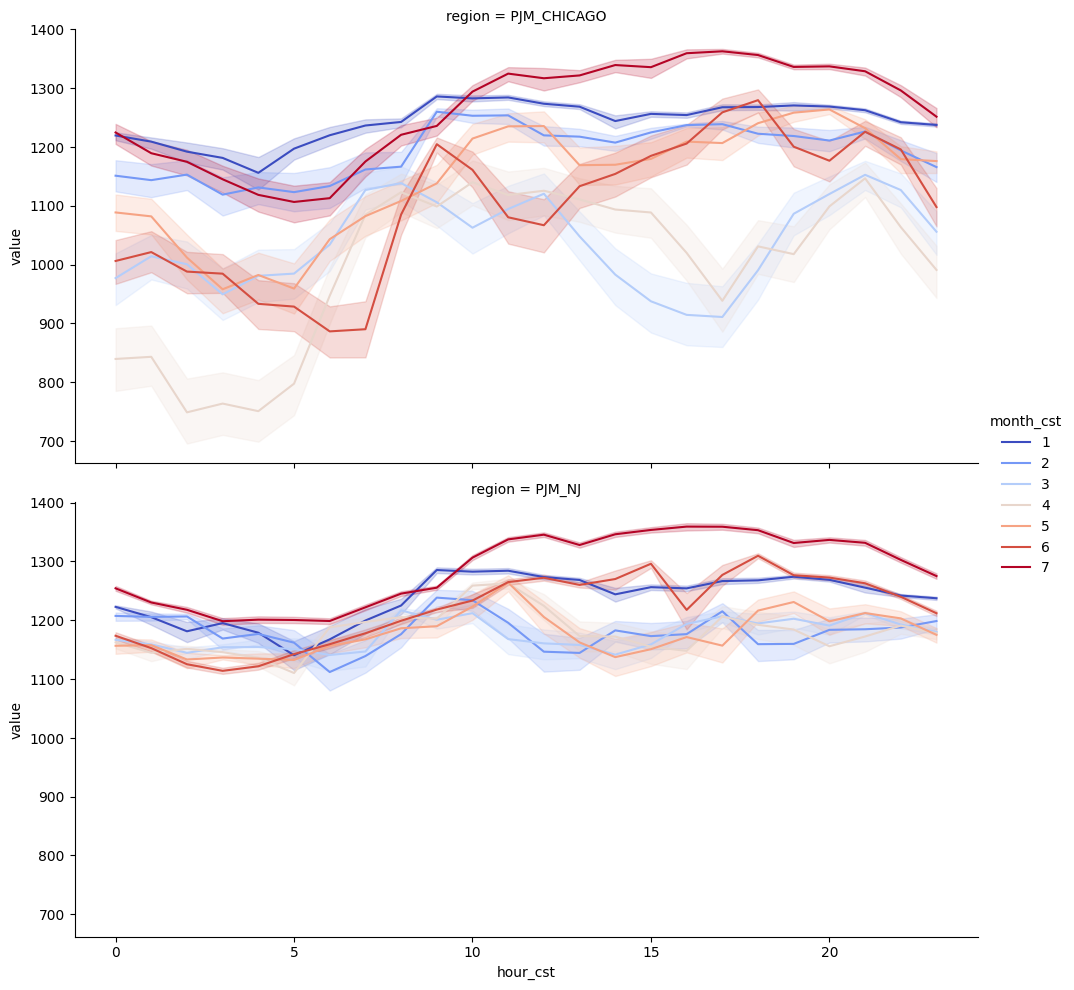

In [8]:
f = plt.figure(figsize=(20,8))
sns.relplot(
    data=df.query('date_cst > datetime.date(2024, 1, 1)'),
    kind="line",
    x="hour_cst", 
    y="value",
    hue="month_cst",
    row="region",
    aspect = 2,
    palette = plt.get_cmap('coolwarm',12),
    legend='full'
)

f.show()

In [11]:
hour_avg = df.groupby(["year","region","month_est","date_est","hour_est"])["value"].describe().reset_index()

In [15]:
hour_avg_rank = hour_avg.groupby(["year","region","date_cst"])["mean"].nsmallest(6).reset_index().set_index("level_3").merge(hour_avg[["hour_cst","std","min","25%","50%","75%","max"]], left_index=True,right_index=True)

<Axes: xlabel='hour_cst', ylabel='percent'>

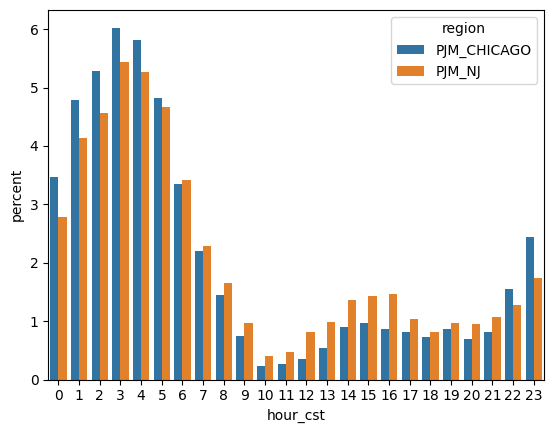

In [18]:
sns.countplot(data = hour_avg_rank, x = "hour_cst", hue="region", stat="percent")
#hour_avg_rank.hour_cst.value_counts(normalize = True).plot(kind = "bar")

<Axes: xlabel='hour_est', ylabel='mean'>

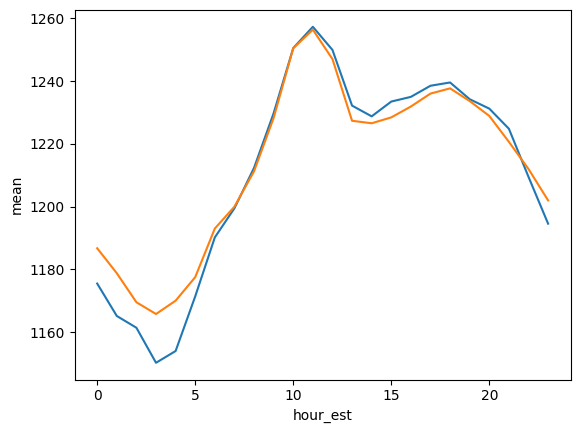

In [13]:
sns.lineplot(hour_avg.groupby(["region","hour_est"])["mean"].median().reset_index(), x = "hour_est", y = "mean", hue="region", legend=False)

<Axes: xlabel='hour_est', ylabel='mean'>

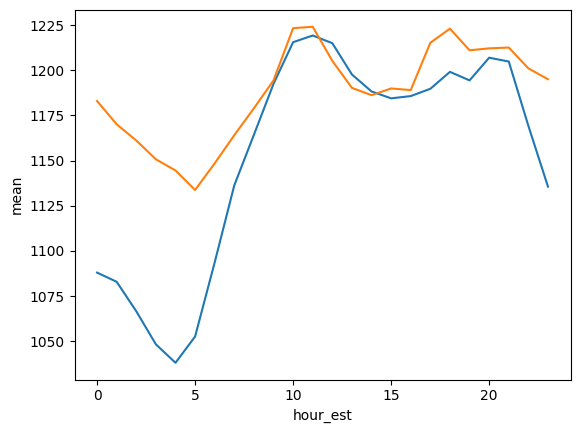

In [15]:
sns.lineplot(hour_avg.groupby(["region","hour_est"])["mean"].mean().reset_index(), x = "hour_est", y = "mean", hue="region", legend=False)

<Axes: xlabel='hour_cst', ylabel='mean'>

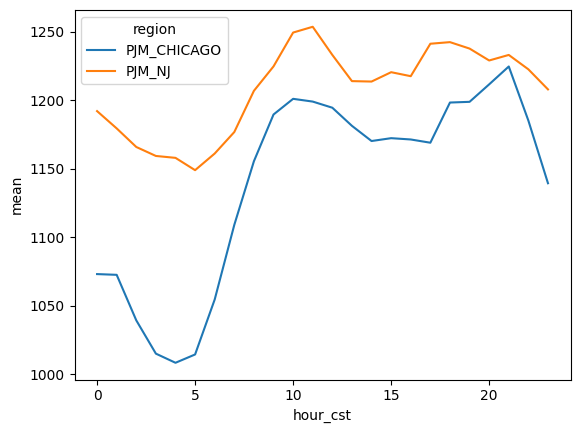

In [21]:
sns.lineplot(hour_avg.query('year > 2023').groupby(["region","hour_cst"])["mean"].mean().reset_index(), x = "hour_cst", y = "mean", hue="region")

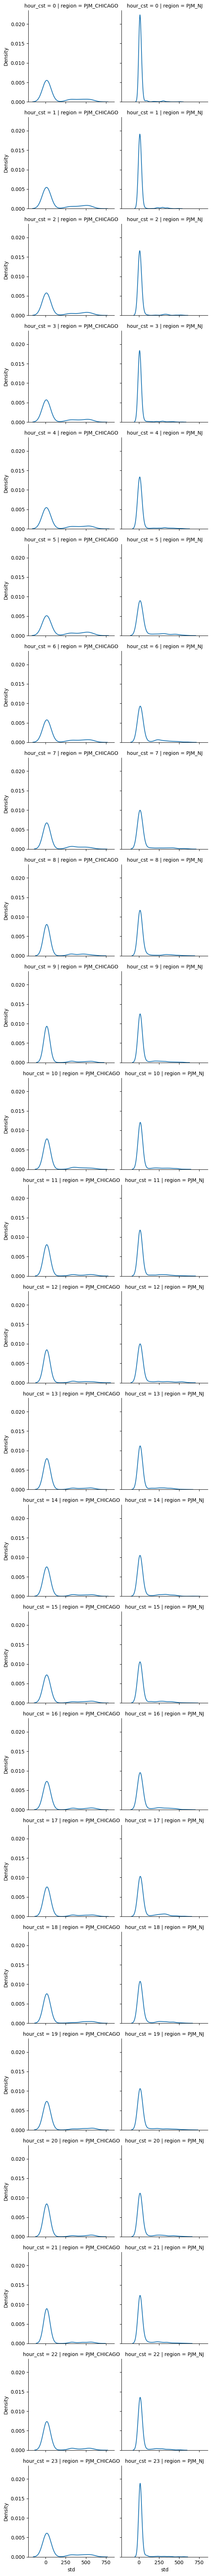

In [22]:
g = sns.FacetGrid(hour_avg, col="region",sharex=True, row="hour_cst")
g.map(sns.kdeplot,"std")

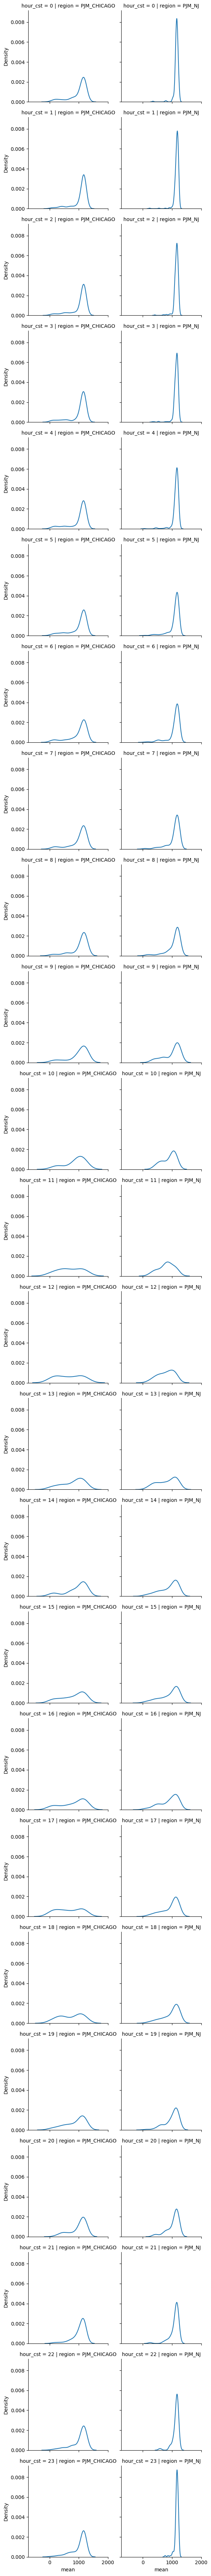

In [23]:
g = sns.FacetGrid(hour_avg_rank, col="region",sharex=True, row="hour_cst")
g.map(sns.kdeplot,"mean")

## By Trading Hour

In [24]:
df["trading_hour"] = [True if x in [8,9,10,11,12,13,14,15,16,17] else False for x in df["hour_cst"]]